In [ ]:
from __future__ import annotations

import os

import numpy as np

from calibrated_response.maxent_pgmax import DistributionBuilder, SolverConfig
from calibrated_response.models.query import (
    ConditionalProbabilityEstimate,
    ExpectationEstimate,
    InequalityProposition,
    ProbabilityEstimate,
)
from calibrated_response.models.variable import ContinuousVariable

# Work around pgmax/numba cache behavior seen in some environments.
os.environ.setdefault("NUMBA_DISABLE_JIT", "1")

# Define two simple continuous variables on [0, 1] -- no LLM required.
x_var = ContinuousVariable(
    name="X",
    description="Test variable X",
    lower_bound=0.0,
    upper_bound=1.0,
    unit="a",
)
y_var = ContinuousVariable(
    name="Y",
    description="Conditioned variable Y",
    lower_bound=0.0,
    upper_bound=1.0,
    unit="b",
)
variables = [x_var, y_var]

# P(X < 0.3) = 0.8
est1 = ProbabilityEstimate(
    id="p_x_lt_0_3",
    proposition=InequalityProposition(
        variable="X",
        variable_type="continuous",
        threshold=0.3,
        is_lower_bound=False,
    ),
    probability=0.8,
)

# P(Y > 0.75 | X > 0.5) = 0.9
x_cond = InequalityProposition(
    variable="X",
    variable_type="continuous",
    threshold=0.5,
    is_lower_bound=True,
)
y_prop = InequalityProposition(
    variable="Y",
    variable_type="continuous",
    threshold=0.75,
    is_lower_bound=True,
)
est2 = ConditionalProbabilityEstimate(
    id="p_y_gt_0_75_given_x_gt_0_5",
    proposition=y_prop,
    conditions=[x_cond],
    probability=0.9,
)

# E[Y] = 0.8
est3 = ExpectationEstimate(id="e_y", variable="Y", expected_value=0.8)

estimates = [est1, est2, est3]

print("Variables and constraints:")
print(" -", x_var.name, x_var.get_domain())
print(" -", y_var.name, y_var.get_domain())

config = SolverConfig(
    max_bins=10,
    bp_iters=200,
    damping=0.2,
    unary_strength=2.5,
    expectation_strength=0.03,
    conditional_strength=1.5,
)
builder = DistributionBuilder(
    variables=variables,
    estimates=estimates,
    solver_config=config,
)

Variables and constraints:
 - X (0.0, 1.0)
 - Y (0.0, 1.0)


In [ ]:
distribution, info = builder.build(target_variable="X")

print("\nSolver diagnostics:")
print(" - n_variables:", info.get("n_variables"))
print(" - n_estimates:", info.get("n_estimates"))
print(" - n_pairwise_factors:", info.get("n_pairwise_factors"))
skipped = info.get("skipped_constraints") or []
print(" - skipped_constraints:", len(skipped))
for msg in skipped:
    print("   *", msg)

# Check X marginal mass at or below 0.5 (similar sanity signal to original example)
bin_edges = np.array(distribution.bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
probs = np.array(distribution.bin_probabilities)
mass_left = float(probs[bin_centers <= 0.5].sum())
print(f"\nMass on X bins with center <= 0.5: {mass_left:.6f}")

all_marginals = builder.get_all_marginals(info)
y_dist = all_marginals["Y"]
y_probs = np.array(y_dist.bin_probabilities)
print(
    "Y marginal stats: "
    f"min={y_probs.min():.4f}, max={y_probs.max():.4f}, mean={y_probs.mean():.4f}"
)

# Quick scalar summary for X
x_mean = float(np.sum(probs * bin_centers))
x_var_value = float(np.sum(probs * (bin_centers - x_mean) ** 2))
x_std = float(np.sqrt(x_var_value))
print("\nX summary:")
print(f" - mean: {x_mean:.4f}")
print(f" - std: {x_std:.4f}")
print(f" - q10: {distribution.quantile(0.1):.4f}")
print(f" - q50: {distribution.quantile(0.5):.4f}")
print(f" - q90: {distribution.quantile(0.9):.4f}")


Solver diagnostics:
 - n_variables: 2
 - n_estimates: 3
 - n_pairwise_factors: 1
 - skipped_constraints: 0

Mass on X bins with center <= 0.5: 0.961172
Y marginal stats: min=0.0043, max=0.1285, mean=0.1000

X summary:
 - mean: 0.1735
 - std: 0.1437
 - q10: 0.0312
 - q50: 0.1562
 - q90: 0.2811


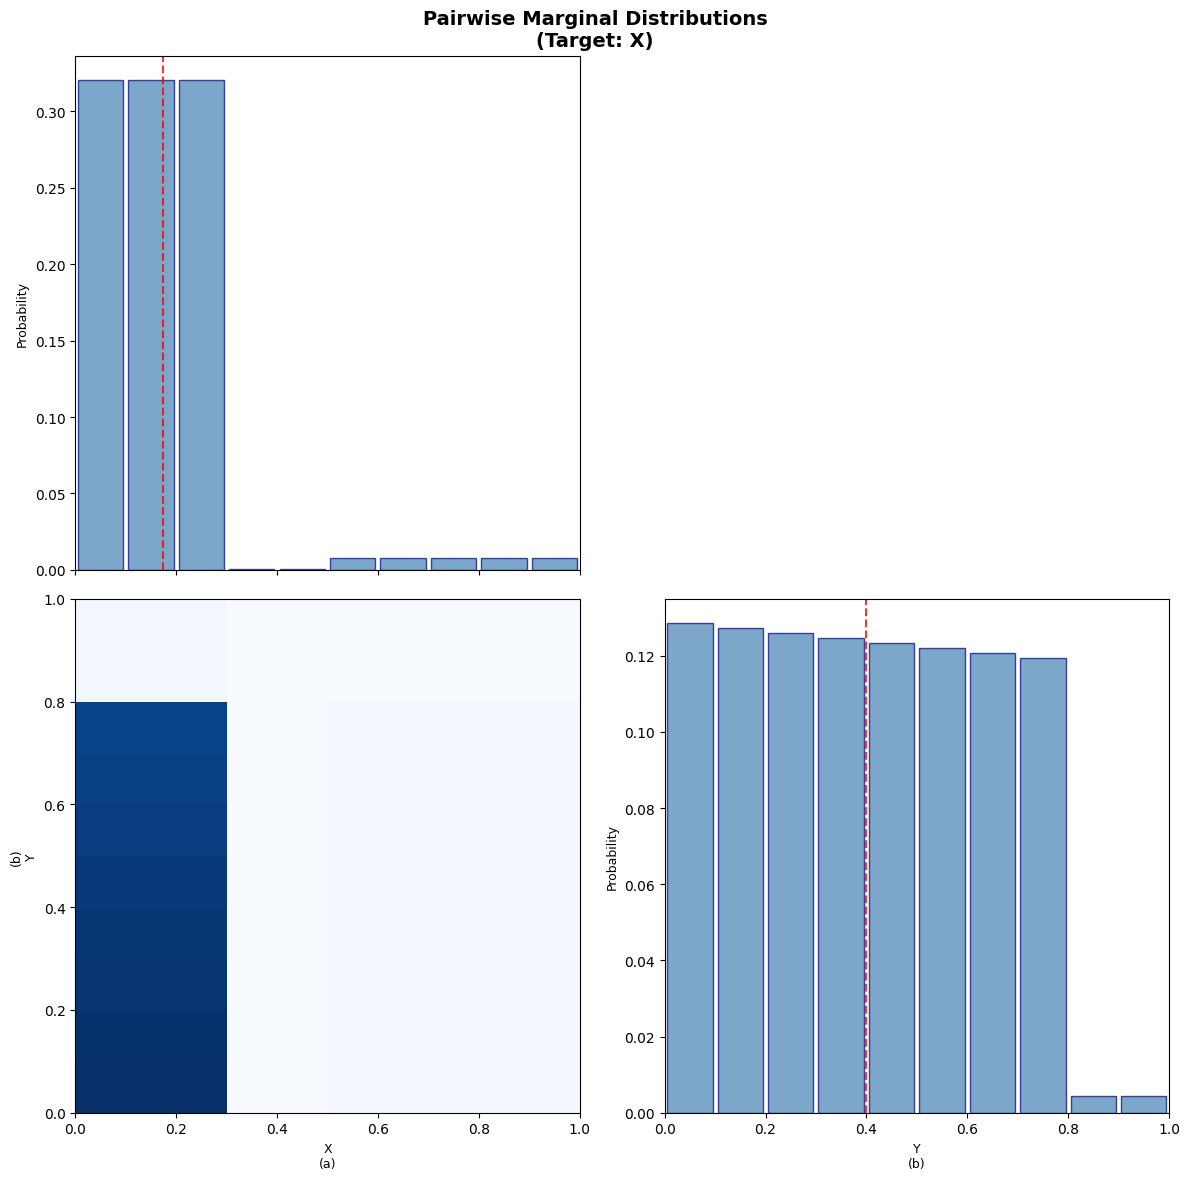

In [4]:
from calibrated_response.visualization.pairplot import plot_pairwise_marginals
import matplotlib.pyplot as plt

# Get the joint distribution and bin edges from the last build
joint_dist = info['joint_distribution']
bin_edges = info['bin_edges_list']

# Create the pairwise plot
fig = plot_pairwise_marginals(
    joint_distribution=joint_dist,
    bin_edges_list=bin_edges,
    variables=variables,
    target_variable=variables[0].name,
    constraints=[], #builder.constraints,
    figsize=(12, 12),
    cmap='Blues',
)

plt.show()